In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_path = '../agricultural drone/Train/'
test_path =  '../agricultural drone/Test/'

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224,3)

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 subset='training')

val_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 subset='validation')

test_generator  = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory(test_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",shuffle=False,
                                                 batch_size=BATCH_SIZE)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=IMAGE_SIZE))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

for layer in baseModel.layers:
    layer.trainable = False

model = Model(inputs=baseModel.input, outputs=headModel)

opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

In [ ]:
early_stop = EarlyStopping(patience=2,monitor='val_loss')
results = model.fit_generator(train_data,epochs=5,
                              validation_data=val_data,
                             callbacks=[early_stop])


In [ ]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [ ]:
test_pred = model.predict_generator(test_data)
pred_class = [np.argmax(x) for x in test_pred]
test_data.class_indices
true_class = test_data.classes

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_class,pred_class))
sns.heatmap(confusion_matrix(true_class,pred_class),annot=True)
mapping_class = test_data.class_indices
mapping_class = dict([(value, key) for key, value in mapping_class.items()]) 

In [ ]:
images, labels = next(iter(test_data))
images = images.reshape(64, 224,224,3)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images[:16], labels[:16]):
    ax.imshow(img)
    true_label = mapping_class[np.argmax(label)]
    
    pred_prob = model.predict(img.reshape(1, 224,224, 3))
    pred_label = mapping_class[np.argmax(pred_prob)]
    
    prob_class = np.max(pred_prob) * 100
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 12)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 10,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("PREDICTION for 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

In [ ]:
images, labels = next(iter(test_data))
images = images.reshape(64, 224,224,3)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images[:16], labels[:16]):
    ax.imshow(img)
    true_label = mapping_class[np.argmax(label)]
    
    pred_prob = model.predict(img.reshape(1, 224,224, 3))
    pred_label = mapping_class[np.argmax(pred_prob)]
    
    prob_class = np.max(pred_prob) * 100
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 12)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 10,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("PREDICTION for 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

In [ ]:
model.save('weed_detection.h5')

In [51]:
with open(train_json,'r') as train:
    
    train_region = json.load(train)
with open(test_json,'r') as test:
    test_region = json.load(test)
train_images_list = list(train_region.keys())
test_images_list = list(test_region.keys())

NameError: name 'train_json' is not defined

In [52]:
labels = pd.read_csv(label_csv)
labels.head()

NameError: name 'label_csv' is not defined

In [53]:
model = tf.keras.models.load_model(model_path)

In [54]:
model_without_last_2FC = tf.keras.models.Model(model.inputs,model.layers[-5].output)

In [55]:
train_features = []

test_features = []


for index in tqdm(range(len(labels))):
    id = labels.loc[index,'filename']
    img = cv2.imread(images_path + id)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    xmin,ymin,xmax,ymax = int(labels.loc[index,'xmin']) ,int(labels.loc[index,'ymin']),int(labels.loc[index,'xmax']),int(labels.loc[index,'ymax'])

    resized = cv2.resize(rgb_img[ymin:ymax,xmin:xmax,:],(224,224))

    feature_of_img = model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255)
    
    if id in train_images_list:
        
        train_features.append([feature_of_img,labels.loc[index,'class']])
        
    else:
        test_features.append([feature_of_img,labels.loc[index,'class']])

NameError: name 'labels' is not defined

In [ ]:
for index,img in tqdm(enumerate(os.listdir(negative_ex_path)[:5000])):  #only extracting for 10,000 images
    img = cv2.imread(negative_ex_path +img  )
    img = img.astype('uint8')
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #images already in (224,224,3)
    feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
    if index<3500:
        train_features.append([feature_of_img,'background'])
    else:
        test_features.append([feature_of_img,'background'])

In [56]:
import random
random.shuffle(train_features)
X_train = np.array([x[0] for x in train_features])
X_train = X_train.reshape(-1,4096)
y_train = [x[1] for x in train_features]
y_train = np.array(y_train).reshape(-1,1)
X_test = np.array([x[0] for x in test_features])
X_test = X_test.reshape(-1,4096)
y_test = [x[1] for x in test_features]
y_test = np.array(y_test).reshape(-1,1)

In [57]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier


In [58]:
svm_model_linear = SVC(kernel = 'linear', C = 1,probability=True).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 4096)) while a minimum of 1 is required.

In [59]:
accuracy = svm_model_linear.score(X_test, y_test)
accuracy

NameError: name 'svm_model_linear' is not defined

In [60]:

cm = confusion_matrix(y_test, svm_predictions) 
sns.heatmap(cm,annot=True)

NameError: name 'svm_predictions' is not defined

In [61]:
img = cv2.imread(negative_ex_path + os.listdir(negative_ex_path)[45] )
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

NameError: name 'negative_ex_path' is not defined

In [ ]:
feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
svm_model_linear.predict(feature_of_img)
svm_model_linear.predict_proba(feature_of_img)
svm_model_linear.classes_

In [ ]:
img = cv2.imread(images_path+'agri_0_1024.jpeg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
resized = cv2.resize(rgb,(224,224))
plt.imshow(resized)

In [30]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

NameError: name 'svm_model_linear' is not defined

In [ ]:
import pickle

with open('svm_classifier.pkl','wb') as svm_model:
    pickle.dump(svm_model_linear , svm_model)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
import pickle
from sklearn.svm import SVC

In [2]:
model_path = '../agricultural drone/weed_detection.h5'
test_img_path = '../agricultural drone/Test'
images_path = '../agricultural drone/agri_data/data/'
svm_model_path = '../agricultural drone/svm_classifier.pkl'
images_name = [x for x in os.listdir(images_path) if x.endswith('.jpeg')]

In [3]:
model = tf.keras.models.load_model(model_path)
model.summary()
model_without_last_two_fc = tf.keras.models.Model(model.inputs,model.layers[-5].output)
model_without_last_two_fc.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

In [4]:
with open(svm_model_path,'rb') as svm:
    svm_model = pickle.load(svm)


In [5]:
def iou_calc(bb1 , bb2):
  
    true_xmin, true_ymin, true_width, true_height  = bb1
    bb_xmin, bb_ymin,  bb_width, bb_height = bb2

    true_xmax = true_xmin + true_width
    true_ymax = true_ymin + true_height
    bb_xmax = bb_xmin + bb_width
    bb_ymax = bb_ymin + bb_height

    #calculating area
    true_area = true_width * true_height
    bb_area   = bb_width * bb_height 

    #calculating itersection cordinates
    inter_xmin = max(true_xmin , bb_xmin) 
    inter_ymin = max(true_ymin , bb_ymin)
    inter_xmax = min(true_xmax , bb_xmax)
    inter_ymax = min(true_ymax , bb_ymax)

    if inter_xmax <= inter_xmin or inter_ymax <= inter_ymin:
        iou = 0


    else:
        inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)


        iou = inter_area / (true_area + bb_area - inter_area)
        
    assert iou<=1
    assert iou>=0
    
    return iou

def detection(images_path,confidence=0.9,iou_thresh=0.1):
    
    # appling selective search
    img = plt.imread(images_path)
    cv2.setUseOptimized(True);
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    sel_rects = rects[:2000]
    
    pred_crop=[]
    pred_weed=[]
    for index, rect in tqdm(enumerate(sel_rects)):

        x,y,w,h = rect
        roi = img[y:y+h,x:x+w,:]
        resized_roi = cv2.resize(roi,(224,224))/255
        
        # Feature extraction
        
        feature = model_without_last_two_fc.predict(resized_roi.reshape(-1,224,224,3))
        
        # SVM prediction
        pred = svm_model.predict_proba(feature.reshape(-1,4096))
        pred_lab=svm_model.predict(feature.reshape(-1,4096))

        if pred_lab == 'crop' and np.max(pred)>confidence:
            pred_crop.append([list(rect),np.max(pred)])
        elif pred_lab=='weed' and np.max(pred)>confidence:
            pred_weed.append([list(rect),np.max(pred)])
            
    final = []
    
    # Detection for crop class
    if len(pred_crop) != 0:
        pred_score_crop = [x[1] for x in pred_crop]
        pred_bb_crop = [x[0] for x in pred_crop]

        for i in range(len(pred_crop)):
            temp_bb , temp_score = pred_bb_crop.copy() , pred_score_crop.copy()
            if len(temp_bb) !=0:

                max_score_box = temp_bb[np.argmax(temp_score)]

                if [max_score_box,np.max(temp_score)] not in final:
                    final.append([max_score_box,np.max(temp_score),'crop'])
                    index_should_del = []

                    for ind,other_bb in enumerate(temp_bb):
                        iou_score = iou_calc(max_score_box , other_bb)
                        
                        # Non maximum suppression(nms)
                        
                        if iou_score >= iou_thresh:
                            index_should_del.append(ind)

                    pred_bb_crop    = []
                    pred_score_crop = []
                    for bb_index ,bb_value in enumerate(temp_bb) :
                        if bb_index not in index_should_del:
                            pred_bb_crop.append(bb_value)

                    for score_index ,score_value in enumerate(temp_score) :
                        if score_index not in index_should_del:
                            pred_score_crop.append(score_value)
                else:
                    continue

            else:
                break

    # Detection for weed class

    if len(pred_weed) != 0:
        pred_score_weed = [x[1] for x in pred_weed]
        pred_bb_weed = [x[0] for x in pred_weed]

        for i in range(len(pred_weed)):
            temp_bb , temp_score = pred_bb_weed.copy() , pred_score_weed.copy()
            if len(temp_bb) !=0:

                max_score_box = temp_bb[np.argmax(temp_score)]

                if [max_score_box,np.max(temp_score)] not in final:
                    final.append([max_score_box,np.max(temp_score),'weed'])
                    index_should_del = []

                    for ind,other_bb in enumerate(temp_bb):
                        iou_score = iou_calc(max_score_box , other_bb)

                        if iou_score >= iou_thresh:
                            index_should_del.append(ind)

                    pred_bb_weed    = []
                    pred_score_weed = []
                    for bb_index ,bb_value in enumerate(temp_bb) :
                        if bb_index not in index_should_del:
                            pred_bb_weed.append(bb_value)

                    for score_index ,score_value in enumerate(temp_score) :
                        if score_index not in index_should_del:
                            pred_score_weed.append(score_value)
                else:
                    continue

            else:
                break
    
   
    imOut = img.copy()
    for rect,score,cls in final:
        
        x,y,w,h = rect
        if cls == 'weed':
            color =(255,0,0)
        if cls == 'crop':
            color = (0,255,0)

        cv2.rectangle(imOut,(x,y),(x+w,y+h),color,2)

        cv2.putText(imOut,cls+':'+str(round(score*100,2)),(x,y-8),cv2.FONT_HERSHEY_SIMPLEX,1, color, 2, cv2.LINE_AA)
    plt.imshow(imOut)
    cv2.imwrite('prediction.jpeg',imOut)
   

    return final 


2000it [07:09,  4.66it/s]


[[[287, 345, 25, 24], 0.9368548553443465, 'crop'],
 [[100, 176, 412, 336], 0.9999993471394855, 'weed'],
 [[0, 0, 232, 274], 0.9493597404654379, 'weed'],
 [[413, 0, 99, 127], 0.9415520623182048, 'weed']]

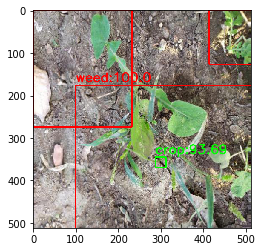

In [6]:

detection(images_path+images_name[1100])